In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0-dev20210602


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-06-07 13:14:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.16, 34.64.4.80, 34.64.4.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.007s  

2021-06-07 13:14:11 (10.2 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



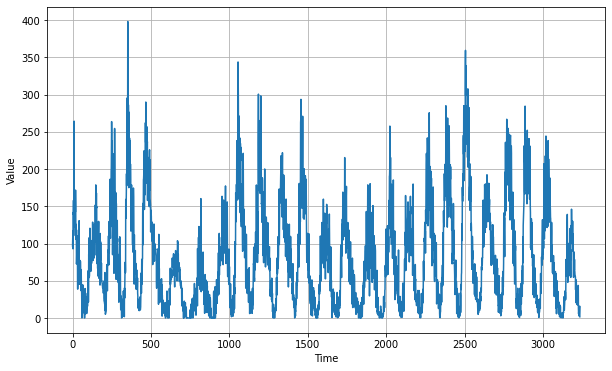

In [10]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

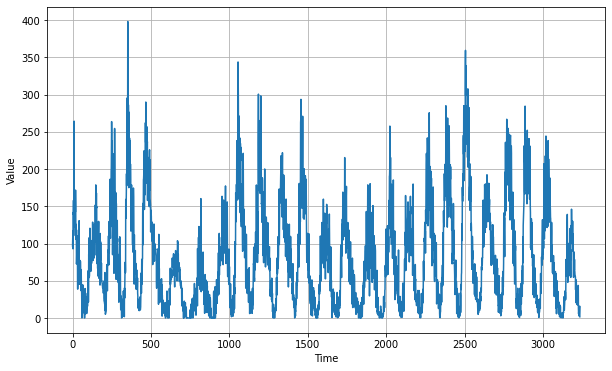

In [11]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [12]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=32, kernel_size=5,
      strides=1, padding="causal",
      activation="relu",
      input_shape=[None, 1]
  ),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 4s 126ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 2s 126ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 2s 126ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 2s 126ms/step - loss: 72.2678 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 2s 126ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 2s 126ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 2s 127ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 2s 125ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 2s 127ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 2s 128ms/step - loss: 52.3436 - mae: 52.8399
Epoch 11/100
12/12 

12/12 [==============================] - 2s 123ms/step - loss: 20.9418 - mae: 21.4352
Epoch 84/100
12/12 [==============================] - 2s 126ms/step - loss: 25.2287 - mae: 25.7233
Epoch 85/100
12/12 [==============================] - 2s 123ms/step - loss: 30.7026 - mae: 31.1984
Epoch 86/100
12/12 [==============================] - 2s 123ms/step - loss: 31.0145 - mae: 31.5096
Epoch 87/100
12/12 [==============================] - 2s 124ms/step - loss: 40.7596 - mae: 41.2559
Epoch 88/100
12/12 [==============================] - 2s 127ms/step - loss: 57.0829 - mae: 57.5812
Epoch 89/100
12/12 [==============================] - 2s 125ms/step - loss: 55.2702 - mae: 55.7682
Epoch 90/100
12/12 [==============================] - 2s 126ms/step - loss: 53.2016 - mae: 53.6998
Epoch 91/100
12/12 [==============================] - 2s 127ms/step - loss: 55.0655 - mae: 55.5638
Epoch 92/100
12/12 [==============================] - 2s 127ms/step - loss: 54.4209 - mae: 54.9191
Epoch 93/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

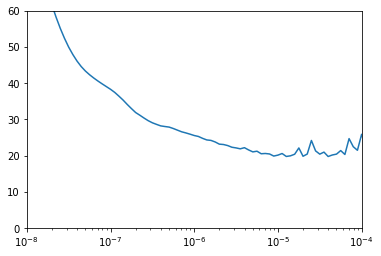

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [21]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [22]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=60, kernel_size=5,
      strides=1, padding="causal",
      activation="relu",
      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [23]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(train_set,epochs=500)

/home/fabian/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
30/30 [==============================] - 4s 69ms/step - loss: 38.9182 - mae: 39.4146
Epoch 2/500
30/30 [==============================] - 2s 69ms/step - loss: 25.7635 - mae: 26.2580
Epoch 3/500
30/30 [==============================] - 2s 70ms/step - loss: 22.0843 - mae: 22.5780
Epoch 4/500
30/30 [==============================] - 2s 69ms/step - loss: 20.4690 - mae: 20.9621
Epoch 5/500
30/30 [==============================] - 2s 69ms/step - loss: 19.7810 - mae: 20.2734
Epoch 6/500
30/30 [==============================] - 2s 69ms/step - loss: 19.2822 - mae: 19.7745
Epoch 7/500
30/30 [==============================] - 2s 69ms/step - loss: 18.7217 - mae: 19.2137
Epoch 8/500
30/30 [==============================] - 2s 69ms/step - loss: 18.1210 - mae: 18.6127
Epoch 9/500
30/30 [==============================] - 2s 69ms/step - loss: 18.0685 - mae: 18.5600
Epoch 10/500
30/30 [==============================] - 2s 69ms/step - loss: 18.1276 - mae: 18.6190
Epoch 11/500
30/30 [=========

30/30 [==============================] - 2s 69ms/step - loss: 16.3676 - mae: 16.8558
Epoch 85/500
30/30 [==============================] - 2s 69ms/step - loss: 16.4166 - mae: 16.9055
Epoch 86/500
30/30 [==============================] - 2s 69ms/step - loss: 16.8823 - mae: 17.3715
Epoch 87/500
30/30 [==============================] - 2s 69ms/step - loss: 16.5763 - mae: 17.0651
Epoch 88/500
30/30 [==============================] - 2s 69ms/step - loss: 16.4767 - mae: 16.9661
Epoch 89/500
30/30 [==============================] - 2s 69ms/step - loss: 16.6746 - mae: 17.1632
Epoch 90/500
30/30 [==============================] - 2s 69ms/step - loss: 16.3975 - mae: 16.8858
Epoch 91/500
30/30 [==============================] - 2s 69ms/step - loss: 16.4030 - mae: 16.8918
Epoch 92/500
30/30 [==============================] - 2s 69ms/step - loss: 16.3768 - mae: 16.8651
Epoch 93/500
30/30 [==============================] - 2s 69ms/step - loss: 16.3519 - mae: 16.8410
Epoch 94/500
30/30 [=============

30/30 [==============================] - 2s 69ms/step - loss: 15.9352 - mae: 16.4238
Epoch 168/500
30/30 [==============================] - 2s 69ms/step - loss: 16.0389 - mae: 16.5277
Epoch 169/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8649 - mae: 16.3531
Epoch 170/500
30/30 [==============================] - 2s 69ms/step - loss: 15.9984 - mae: 16.4872
Epoch 171/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8723 - mae: 16.3605
Epoch 172/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8749 - mae: 16.3635
Epoch 173/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8865 - mae: 16.3750
Epoch 174/500
30/30 [==============================] - 2s 69ms/step - loss: 16.0252 - mae: 16.5140
Epoch 175/500
30/30 [==============================] - 2s 69ms/step - loss: 15.9115 - mae: 16.4001
Epoch 176/500
30/30 [==============================] - 2s 69ms/step - loss: 15.8211 - mae: 16.3095
Epoch 177/500
30/30 [===

30/30 [==============================] - 2s 70ms/step - loss: 15.6125 - mae: 16.1006
Epoch 250/500
30/30 [==============================] - 2s 70ms/step - loss: 15.5426 - mae: 16.0304
Epoch 251/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4785 - mae: 15.9657
Epoch 252/500
30/30 [==============================] - 2s 69ms/step - loss: 15.5195 - mae: 16.0070
Epoch 253/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4246 - mae: 15.9117
Epoch 254/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4551 - mae: 15.9428
Epoch 255/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4286 - mae: 15.9159
Epoch 256/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4590 - mae: 15.9464
Epoch 257/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4314 - mae: 15.9188
Epoch 258/500
30/30 [==============================] - 2s 69ms/step - loss: 15.4430 - mae: 15.9302
Epoch 259/500
30/30 [===

30/30 [==============================] - 2s 69ms/step - loss: 15.0906 - mae: 15.5770
Epoch 332/500
30/30 [==============================] - 2s 69ms/step - loss: 15.0650 - mae: 15.5509
Epoch 333/500
30/30 [==============================] - 2s 69ms/step - loss: 15.1968 - mae: 15.6836
Epoch 334/500
30/30 [==============================] - 2s 69ms/step - loss: 15.0523 - mae: 15.5385
Epoch 335/500
30/30 [==============================] - 2s 69ms/step - loss: 15.0799 - mae: 15.5659
Epoch 336/500
30/30 [==============================] - 2s 70ms/step - loss: 15.2682 - mae: 15.7551
Epoch 337/500
30/30 [==============================] - 2s 69ms/step - loss: 15.1356 - mae: 15.6220
Epoch 338/500
30/30 [==============================] - 2s 70ms/step - loss: 15.2019 - mae: 15.6883
Epoch 339/500
30/30 [==============================] - 2s 70ms/step - loss: 15.1426 - mae: 15.6296
Epoch 340/500
30/30 [==============================] - 2s 69ms/step - loss: 15.0426 - mae: 15.5291
Epoch 341/500
30/30 [===

30/30 [==============================] - 2s 69ms/step - loss: 14.9162 - mae: 15.4020
Epoch 414/500
30/30 [==============================] - 2s 69ms/step - loss: 15.0988 - mae: 15.5854
Epoch 415/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8693 - mae: 15.3551
Epoch 416/500
30/30 [==============================] - 2s 70ms/step - loss: 15.1508 - mae: 15.6378
Epoch 417/500
30/30 [==============================] - 2s 69ms/step - loss: 14.7662 - mae: 15.2519
Epoch 418/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8894 - mae: 15.3757
Epoch 419/500
30/30 [==============================] - 2s 69ms/step - loss: 14.7292 - mae: 15.2151
Epoch 420/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8213 - mae: 15.3073
Epoch 421/500
30/30 [==============================] - 2s 70ms/step - loss: 14.7918 - mae: 15.2777
Epoch 422/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8233 - mae: 15.3091
Epoch 423/500
30/30 [===

30/30 [==============================] - 2s 70ms/step - loss: 14.6140 - mae: 15.1001
Epoch 496/500
30/30 [==============================] - 2s 69ms/step - loss: 14.4771 - mae: 14.9628
Epoch 497/500
30/30 [==============================] - 2s 69ms/step - loss: 14.4614 - mae: 14.9470
Epoch 498/500
30/30 [==============================] - 2s 70ms/step - loss: 14.4978 - mae: 14.9837
Epoch 499/500
30/30 [==============================] - 2s 69ms/step - loss: 14.5964 - mae: 15.0824
Epoch 500/500
30/30 [==============================] - 2s 69ms/step - loss: 14.8449 - mae: 15.3314


In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

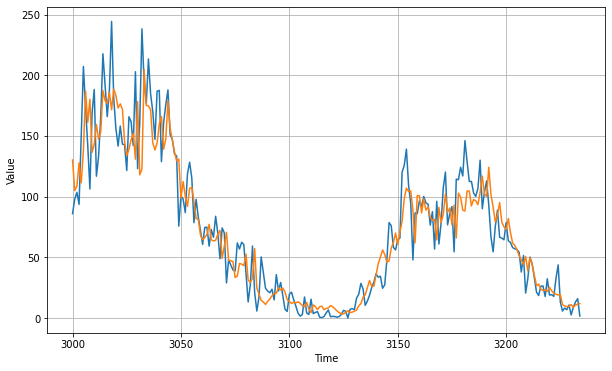

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.22312

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [29]:
loss = history.history['loss']

epochs = range(len(loss))

<Figure size 432x288 with 0 Axes>

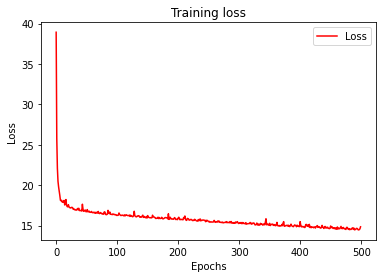

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [31]:
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

<Figure size 432x288 with 0 Axes>

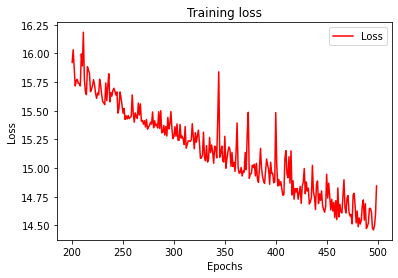

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [33]:
print(rnn_forecast)

[130.16074   105.00503   108.55921   127.88918   111.28739   137.98509
 186.95207   161.15105   180.19531   136.40854   143.2248    159.36522
 147.29564   153.40448   187.42056   179.07565   176.78934   185.80215
 171.53833   188.6018    183.27095   173.01823   176.43288   171.8595
 145.06598   133.83682   138.92445   146.75484   152.02553   130.88458
 178.23648   117.954544  122.781845  204.81177   175.11377   174.75124
 171.47458   144.36726   138.38379   144.29195   159.65797   165.92844
 139.07751   147.41788   178.86006   156.36127   146.61171   137.12177
 129.36017   130.96       98.60675   112.36903   100.410675   91.95022
 106.86622   107.50792    95.833824   81.86158    81.18993    68.33732
  64.411476   66.31052    68.82062    77.16394    64.4289     63.43579
  63.956623   68.972046   72.17538    49.07448    59.236347   70.52527
  47.344734   47.211266   46.410812   33.309017   34.526432   44.926376
  44.36308    43.08504    52.651794   31.192728   29.293636   32.819923
  57.